In [30]:
import optuna
import pickle
from tqdm import tqdm
import numpy as np

from scipy.interpolate import splrep, BSpline
import matplotlib.pyplot as plt
import json


In [31]:
class exp_config:
    inference_folder: str = "."
    ds_name: str = "adult"
    evaluation_metric: str = "acc"  # if sets to "rmse", it is in negative scale


class MySpline:
    def __init__(self, x, y, n_interior_knots=5, k=3):
        """
        1-d B-spline for spline smoothing.
        x: numpy array of shape (n, 1)
        y; numpy array of shape (n, )
        n_interior_knots: number of interior knots (-> quantile of x as interior knots of the spline)
        k: degree of the spline fit (e.g. 3 for cubic spline)
        """

        # specify spline knots based on quantiles of x
        qs = np.linspace(0, 1, n_interior_knots + 2)[1:-1]
        knots = np.quantile(x, qs)
        t, c, k = splrep(x, y, t=knots, k=k)

        dmatrix_raw = BSpline.design_matrix(x.reshape(-1), t, k).toarray()
        xtx = np.linalg.pinv(dmatrix_raw.T @ dmatrix_raw)
        beta_hat = xtx @ dmatrix_raw.T @ y

        sigma_hat = np.sqrt(
            np.sum((y - dmatrix_raw @ beta_hat) ** 2) / (len(y) - len(beta_hat))
        )

        self.tck = (t, c, k)
        self.dmatrix_raw = dmatrix_raw
        self.xtx = xtx
        self.beta_hat = beta_hat
        self.sigma_hat = sigma_hat

    def pred(self, x):
        """Predict y given x using beta_hat (estimated from spline) and get SE for the prediction"""
        if len(x.shape) == 2 and x.shape[1] == 1:
            x = x.reshape(-1)
        dmatrix = BSpline.design_matrix(x, self.tck[0], self.tck[2]).toarray()

        y_pred = dmatrix @ self.beta_hat
        y_pred_se = self.sigma_hat * np.diag(dmatrix @ self.xtx @ dmatrix.T)

        return y_pred, y_pred_se


# ds_anme: evaluation_metric (rmse for regression and acc for classification)
ds_metric = {
    "insurance": "rmse",
    "abalone": "rmse",
    "gesture": "acc",
    "churn2": "acc",
    "california": "rmse",
    "house": "rmse",
    "adult": "acc",
    "fb-comments": "rmse",
}

In [32]:
def retrieve_data(exp_config):
    """
    Retrieve results including fake_to_real_ratio_list, best_score_list, nn_best_score based on experiment configuration.
    """
    if exp_config.evaluation_metric in ["r2", "f1"]:
        # default metrics
        storage_name = f"sqlite:///{exp_config.inference_folder}/ratio_optuna_studies/{exp_config.ds_name}.db"
        pickle_path = f"{exp_config.inference_folder}/fake_to_real_ratio/ratio_list_{exp_config.ds_name}.pkl"
    else:
        storage_name = f"sqlite:///{exp_config.inference_folder}/ratio_optuna_studies/{exp_config.ds_name}_{exp_config.evaluation_metric}.db"
        pickle_path = f"{exp_config.inference_folder}/fake_to_real_ratio/ratio_list_{exp_config.ds_name}_{exp_config.evaluation_metric}.pkl"

    fake_to_real_ratio_list = pickle.load(open(pickle_path, "rb"))
    fake_to_real_ratio_list.sort()
    fake_to_real_ratio_list = np.array(fake_to_real_ratio_list)

    best_score_list = []
    for fake_to_real_ratio in tqdm(fake_to_real_ratio_list):
        study_name = (
            f"catboost_{exp_config.ds_name}_fake_to_real_ratio_{fake_to_real_ratio}"
        )
        study = optuna.load_study(study_name=study_name, storage=storage_name)
        best_score_list.append(study.best_value)

    nn_result_path = f"./tuned_models/mlp/{exp_config.ds_name}_val_metrics.json"
    metric_report = json.load(open(nn_result_path, "r"))
    nn_best_score = metric_report["test"][exp_config.evaluation_metric]

    if exp_config.evaluation_metric == "rmse":
        best_score_list = -np.array(best_score_list)
    else:
        # error mesuure: 1 - r2, 1 - f1, 1 - accuracy
        best_score_list = 1 - np.array(best_score_list)
        nn_best_score = 1 - nn_best_score

    result_dict = {
        "fake_to_real_ratio_list": fake_to_real_ratio_list,
        "best_score_list": best_score_list,
        "nn_best_score": nn_best_score,
    }
    return result_dict


def single_plot(ax, ds_name="adult", se_scale=1.96, error_bar=False, **kwargs):
    """
    Get one single plot of statistical error curve for a given dataset. s is used for controlling spline smoothing
    ax: matplotlib axis to be plotted at
    ds_name: dataset name to be plotted, used to extract information based on exp_config
    se_scale: scale of standard error, default is 1.96 for 95% confidence interval
    error_bar: whether to use error bar or using prediction interval. Default is False
    kwargs: other arguments to be passed to MySpline, mainly for n_interior_knots and k
    """

    exp_config.ds_name = ds_name
    exp_config.evaluation_metric = ds_metric[exp_config.ds_name]
    result_dict = retrieve_data(exp_config)

    fake_to_real_ratio = result_dict["fake_to_real_ratio_list"]
    best_score_list = result_dict["best_score_list"]

    syngen_size = fake_to_real_ratio[np.argmin(best_score_list)]  # tuned syngen size

    myspline = MySpline(fake_to_real_ratio[1:], best_score_list[1:], **kwargs)
    xnew = np.linspace(fake_to_real_ratio[1:].min(), fake_to_real_ratio[1:].max(), 200)
    y_pred, y_pred_se = myspline.pred(xnew)

    # 1. add scatter plot of observed data and fitted spline
    if not error_bar:
        ## smoothing spline and fitted values
        spline_obs = ax.scatter(
            fake_to_real_ratio[1:],
            best_score_list[1:],
            marker="s",
            label="observed",
            # mew=2,
            # linestyle="-",
            # markersize=8,
            # linewidth=2,
        )
        spline_fitted = ax.plot(xnew, y_pred, "-", label="fitted")
        se_scale = 1.96
        ax.fill_between(
            xnew,
            y_pred - se_scale * y_pred_se,
            y_pred + se_scale * y_pred_se,
            alpha=0.2,
            color="C0",
        )
        initial_legend = plt.legend(
            handles=[spline_obs, spline_fitted[0]],
            loc="upper right",
            fontsize=14,
            bbox_to_anchor=[1, 0.8],
        )
    else:
        ## error bar based on spline regression model
        x, y = fake_to_real_ratio[1:], best_score_list[1:]
        _, y_pred_se = myspline.pred(x)
        sigma_hat = myspline.sigma_hat
        y_se = np.sqrt(y_pred_se**2 + sigma_hat**2)

        spline_fitted = ax.errorbar(
            x, y, yerr=y_se, fmt="o", elinewidth=1.5, label="observed"
        )

        initial_legend = plt.legend(
            handles=[spline_fitted],
            loc="upper right",
            fontsize=14,
            bbox_to_anchor=[1, 0.6],
        )

    plt.gca().add_artist(initial_legend)

    y_min, y_max = ax.get_ylim()
    y_min, y_max = min(y_min, result_dict["nn_best_score"], best_score_list.min()), max(
        y_max, result_dict["nn_best_score"], best_score_list.max()
    )
    y_min, y_max = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
    ax.set_ylim(y_min, y_max)

    # 2. add horizontal lines for baseline, FNN-reference and best syn-boost error curve
    base_line_value = best_score_list[0]
    tuned_value = (
        min(best_score_list)
        if exp_config.evaluation_metric != "rmse"
        else min(best_score_list)
    )
    error_catboost = ax.axhline(
        base_line_value, linestyle="--", color="grey", label="CatBoost"
    )
    error_synboost = ax.axhline(
        tuned_value, linestyle="--", color="C0", label="Syn-Boost"
    )
    error_fnn = ax.axhline(
        result_dict["nn_best_score"], linestyle="--", color="C1", label="FNN"
    )

    ax2 = ax.twinx()
    ax2.set_yticks([base_line_value, tuned_value, result_dict["nn_best_score"]])

    ax.tick_params(axis="both", which="major", labelsize=14)
    ax2.set_ylim(ax.get_ylim())
    ax2.tick_params(axis="both", which="major", labelsize=14)

    first_legend = plt.legend(
        handles=[error_catboost, error_synboost, error_fnn],
        loc="upper right",
        fontsize=14,
        ncol=3,
        bbox_to_anchor=[1, 1.088],
    )
    plt.gca().add_artist(first_legend)

    # 3. add legends of sizes: pretrain size and tuned Syn-Boost size
    size_marker_kargs = {
        "y": y_min,
        "marker": "*",
        "zorder": 10,
        "clip_on": False,
        "s": 250,
    }
    size_title = plt.plot([], marker="", ls="")[0]
    size_pretrain = ax.scatter(
        x=8 if exp_config.ds_name == "fb-comments" else 4,
        color="C1",
        label="pretrain size",
        **size_marker_kargs,
    )
    size_synboost = ax.scatter(
        x=syngen_size, color="C0", label="Syn-Boost size", **size_marker_kargs
    )
    plt.legend(
        handles=[size_title, size_pretrain, size_synboost],
        loc="upper center",
        bbox_to_anchor=[0.5, -0.12],
        ncol=4,
        fontsize=14,
        columnspacing=8,
        labels=["Data size:", "pretrain size", "Syn-Boost size"],
    )

    # 4. miscellaneous: labels and titles
    if exp_config.evaluation_metric == "rmse":
        y_label = "RMSE"
    elif exp_config.evaluation_metric == "r2":
        y_label = "1 - R2"
    elif exp_config.evaluation_metric == "f1":
        y_label = "1 - F1"
    else:
        y_label = "misclassification error"

    ax.set_xlabel("synthetic to raw ratio", fontsize=18)
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_title(
        exp_config.ds_name.capitalize(),
        weight="bold",
        fontsize=24,
        loc="left",
        y=1.03,
    )

# Test on spline smoothing

Fitting, prediction, and prediction SE.

In [33]:
exp_config.ds_name = "insurance"
exp_config.evaluation_metric = ds_metric[exp_config.ds_name]
result_dict = retrieve_data(exp_config)

100%|██████████| 31/31 [00:06<00:00,  4.77it/s]


In [34]:
X, y = (
    result_dict["fake_to_real_ratio_list"].reshape(-1, 1),
    result_dict["best_score_list"],
)

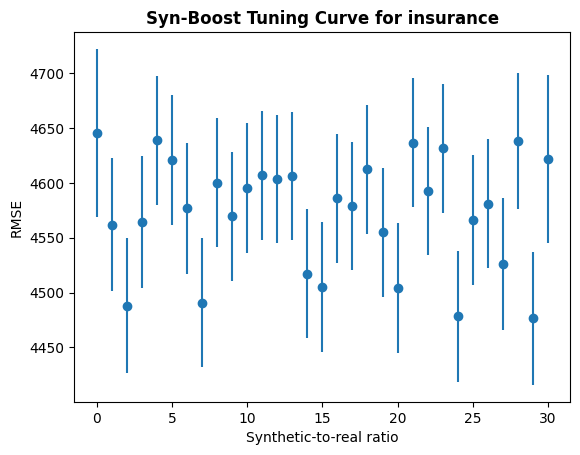

In [35]:
myspline = MySpline(X, y, k=3)

x = X.flatten()
y_pred, y_pred_se = myspline.pred(x)
sigma_hat = myspline.sigma_hat

y_se = np.sqrt(y_pred_se**2 + sigma_hat**2)
# y_se = [sigma_hat] * len(y_pred)
plt.errorbar(x, y, yerr=[y_se, y_se], fmt="o", elinewidth=1.5)

plt.xlabel("Synthetic-to-real ratio")
plt.ylabel("RMSE")
plt.title(f"Syn-Boost Tuning Curve for {exp_config.ds_name}", weight="bold")
plt.show()

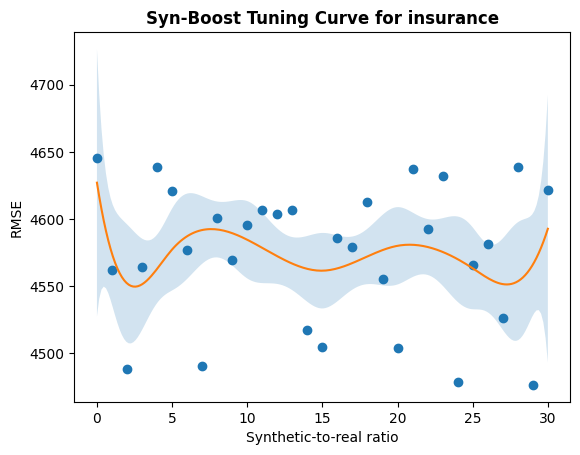

In [36]:
myspline = MySpline(X, y, k=3)

xnew = np.linspace(X.min(), X.max(), 200)
y_pred, y_pred_se = myspline.pred(xnew)

plt.plot(X, y, "o")

plt.plot(xnew, y_pred, "-")
plt.fill_between(xnew, y_pred - 1.96 * y_pred_se, y_pred + 1.96 * y_pred_se, alpha=0.2)

plt.xlabel("Synthetic-to-real ratio")
plt.ylabel("RMSE")
plt.title(f"Syn-Boost Tuning Curve for {exp_config.ds_name}", weight="bold")
plt.show()

# Reproduce all curves

100%|██████████| 31/31 [00:06<00:00,  4.94it/s]


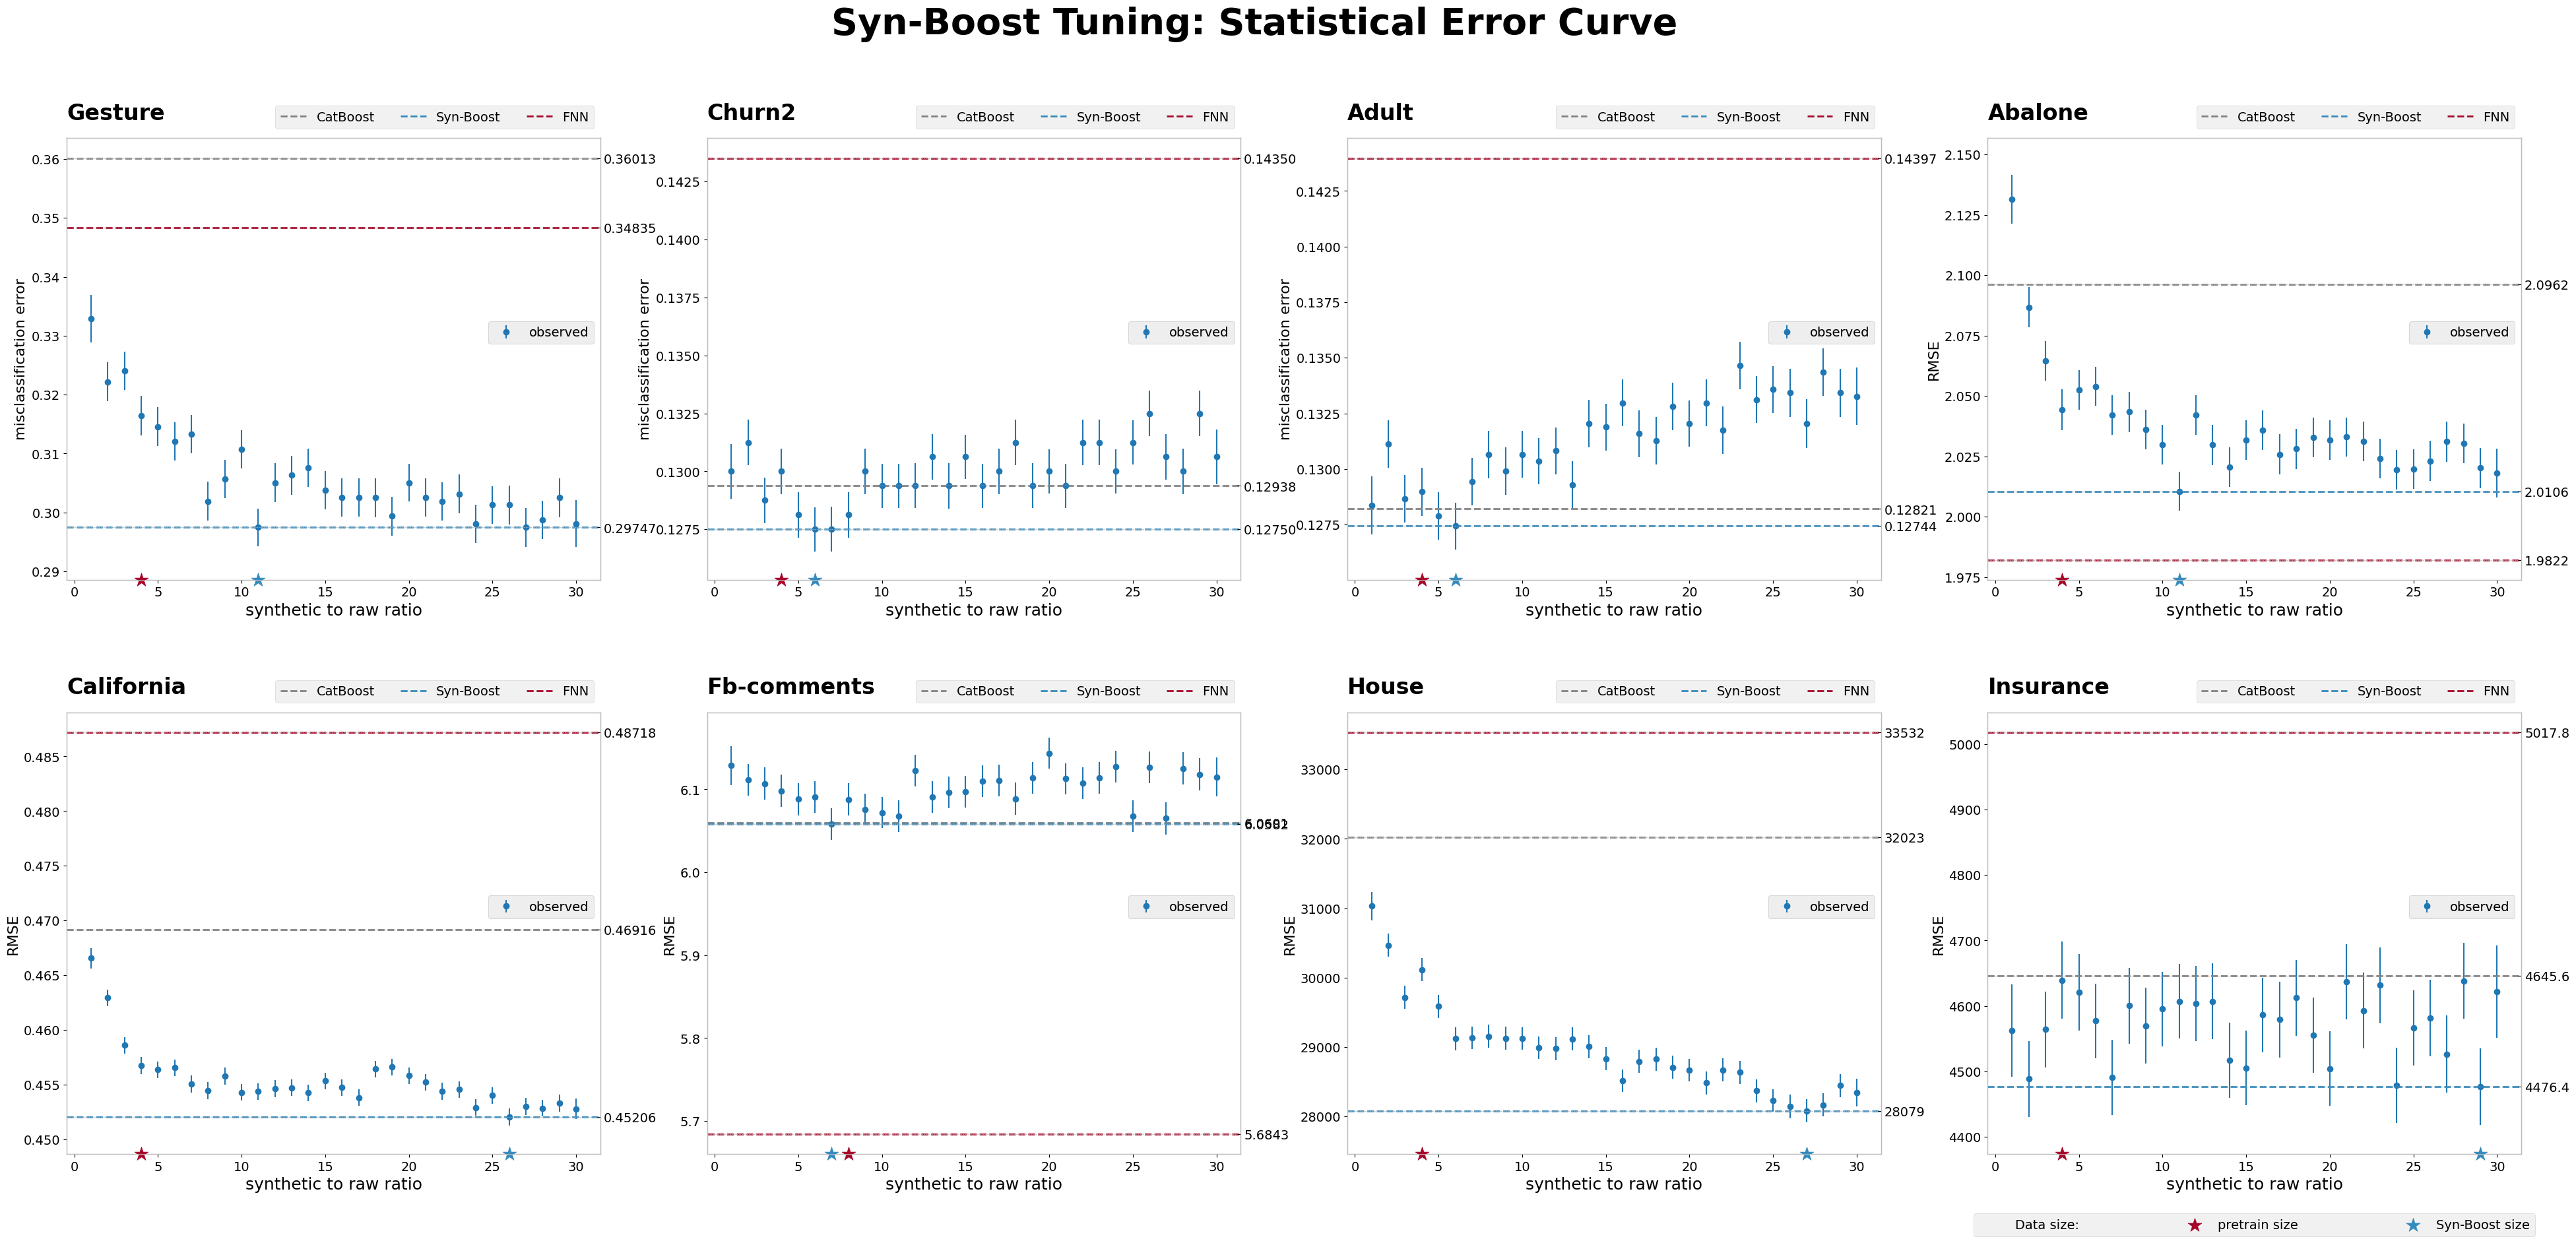

In [37]:
nrows, ncols = 2, 4
single_width, single_height = 12, 10
fig, axs = plt.subplots(
    nrows, ncols, figsize=(single_width * ncols, single_height * nrows)
)
axs = axs.ravel()

plt.style.use("bmh")
ds_names_list = [
    "gesture",
    "churn2",
    "adult",
    "abalone",
    "california",
    "fb-comments",
    "house",
    "insurance",
]
for i, ds_name in enumerate(ds_names_list):
    single_plot(axs[i], ds_name=ds_name, n_interior_knots=5, k=2, error_bar=True)


plt.suptitle(
    "Syn-Boost Tuning: Statistical Error Curve", fontsize=40, weight="bold", y=0.98
)

plt.subplots_adjust(
    hspace=0.3,  # the amount of height reserved for white space between subplots
)